# Part 4

## Correct batch effect

Scgen batch correction.

- **INPUT:**
    -  ```counts_norm.mtx``` 
    -  ```anno_cells_norm.txt``` 
    -  ```anno_samples_norm.txt``` 
    -  ```anno_genes_norm.txt``` 
    -  ```cell_relabelling.csv``` file containing unified cell type annotations. Stored in additional_input_files sub-directory.
    
    
- **OUTPUT:**

    -  ```counts_corr.csv.gz``` 
    -  ```anno_cells_corr.txt``` 
    -  ```anno_samples_corr.txt``` 
    -  ```anno_genes_corr.txt``` 
    -  ```adata_afterCorrection.h5ad```

### load data

In [1]:
import numpy as np
import anndata as ad
import scgen
import scanpy as sc
import pandas as pd
import numba as nb

Global seed set to 0
/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
# read in count table and create an adata object
adata_beforeCorrection = sc.read_mtx("counts_norm.mtx",'float64').T

In [3]:
# read in cell annotation file
anno_cells = pd.read_csv("anno_cells_norm.txt", sep = "\t") 

In [4]:
# read in sample annotation file
anno_samples = pd.read_csv("anno_samples_norm.txt", sep = "\t") 

In [5]:
# read in gene annotation file
anno_genes = pd.read_csv("anno_genes_norm.txt", sep = "\t") 

In [6]:
# load cell subtype and color keys
cell_relabel=pd.read_csv("additional_input_files/cell_relabelling.csv"
                        ,sep=';')

### process data

In [7]:
adata_beforeCorrection.var_names=anno_genes['gene_symbol']
print("adata_beforeCorrection.var_names[1:10]")
print(adata_beforeCorrection.var_names[1:10])
adata_beforeCorrection.var = anno_genes
adata_beforeCorrection.var.index = adata_beforeCorrection.var.index.astype(str)

adata_beforeCorrection.var_names[1:10]
Index(['A1BG-AS1', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AADAT', 'AAED1',
       'AAGAB', 'AAK1'],
      dtype='object', name='gene_symbol')


In [8]:
adata_beforeCorrection.obs_names=anno_cells['cell_ID']
print("adata_beforeCorrection.obs_names[1:10]")
print(adata_beforeCorrection.obs_names[1:10])
adata_beforeCorrection.obs = anno_cells
adata_beforeCorrection.obs.index = adata_beforeCorrection.obs.index.astype(str)

adata_beforeCorrection.obs_names[1:10]
Index(['AML1012-D0_AAAACACCAATC', 'AML1012-D0_AAAATAGCCTTT',
       'AML1012-D0_AAACATTAAACG', 'AML1012-D0_AAACCACGTGCN',
       'AML1012-D0_AAACGCTGGAAN', 'AML1012-D0_AAACTGGTACTA',
       'AML1012-D0_AAACTTGCCCGT', 'AML1012-D0_AAATGAAAGTCC',
       'AML1012-D0_AAATGTACGGTA'],
      dtype='object', name='cell_ID')


### prepare for the visualization

In [9]:
# define colors
colors_cell_type=dict(zip(cell_relabel["cell_type"],cell_relabel["cell_type_color_hex"]))
print(colors_cell_type)

{'B': '#4FC384', 'Mono': '#F09040', 'T': '#4F92EE', 'DC': '#854701', 'Ery': '#F72E3A', 'Megakaryocytes': '#C89B7A', 'NK': '#4F64EE', 'HSPC': '#D040F0'}


In [10]:
#there is an error at line 9, cell_subtype is only 2 values?
adata_beforeCorrection.obs["cell_subtype"].value_counts()

CD4_T        24362
CD8_T        13491
Mono         10502
HSPC          7608
B             5773
cDC           3146
pro_Mono      3056
early_Ery     2596
late_Ery      2377
Plasma         889
pDC            783
Name: cell_subtype, dtype: int64

In [11]:
# add cell_subtype column
cell_subtype = []
for t in adata_beforeCorrection.obs["cell_type_original"]:
    idx=cell_relabel["cell_type_original"]==t
    cell_subtype.append(cell_relabel["cell_subtype"][idx].values[0]) #
adata_beforeCorrection.obs["cell_subtype"] = pd.DataFrame(cell_subtype).values
# re-order such that the cell subtypes apper in the correct order in the legend
adata_beforeCorrection.obs["cell_subtype"]=adata_beforeCorrection.obs["cell_subtype"].astype("category")
adata_beforeCorrection.obs['cell_subtype'].cat.reorder_categories(['HSPC'
                                                  ,'early_Ery'
                                                  ,'late_Ery'
                                                  ,'pro_Mono'
                                                  ,'Mono'
                                                  ,'cDC'
                                                  ,'pDC'
                                                  ,'B'
                                                  ,'Plasma'
                                                  ,'CD4_T'
                                                  ,'CD8_T'], inplace=True)

/tmp/ipykernel_40406/2798501803.py:9: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_beforeCorrection.obs['cell_subtype'].cat.reorder_categories(['HSPC'


In [12]:
# rename "malignangt" columns into "bares_mutatoin"
adata_beforeCorrection.obs["bares_mutation"] = adata_beforeCorrection.obs["malignant"].astype('str')

In [13]:
# define color schemes
colors_cell_subtype=dict(zip(cell_relabel["cell_subtype"],cell_relabel["cell_subtype_color_hex"]))
print(colors_cell_subtype)

colors_cell_type=dict(zip(cell_relabel["cell_type"],cell_relabel["cell_type_color_hex"]))
print(colors_cell_type)

{'B': '#4FC384', 'Mono': '#F09040', 'pro_Mono': '#F0AD40', 'CD4_T': '#4FCCEE', 'CD8_T': '#4F92EE', 'pDC': '#854701', 'cDC': '#B95D10', 'early_Ery': '#F72E3A', 'late_Ery': '#C72D37', 'Megakaryocytes': '#C89B7A', 'NK': '#4F64EE', 'Plasma': '#317E54', 'HSPC': '#D040F0'}
{'B': '#4FC384', 'Mono': '#F09040', 'T': '#4F92EE', 'DC': '#854701', 'Ery': '#F72E3A', 'Megakaryocytes': '#C89B7A', 'NK': '#4F64EE', 'HSPC': '#D040F0'}


In [14]:
adata_beforeCorrection.uns["health_status_colors"] = ["#7C001F" # bordeau for AML
                                                     , "#7ac5cd" # CadetBlue3 for healthy
                                                     ]

adata_beforeCorrection.uns["bares_mutation_colors"] = ["#A6ACAF" # grey for FALSE
                                                  , "#C0392B" # red for TRUE
                                                 ]

In [15]:
print("save adata_beforeCorrection.h5ad")
adata_beforeCorrection.write(filename='adata_beforeCorrection.h5ad')

save adata_beforeCorrection.h5ad


### visualize before batch correction

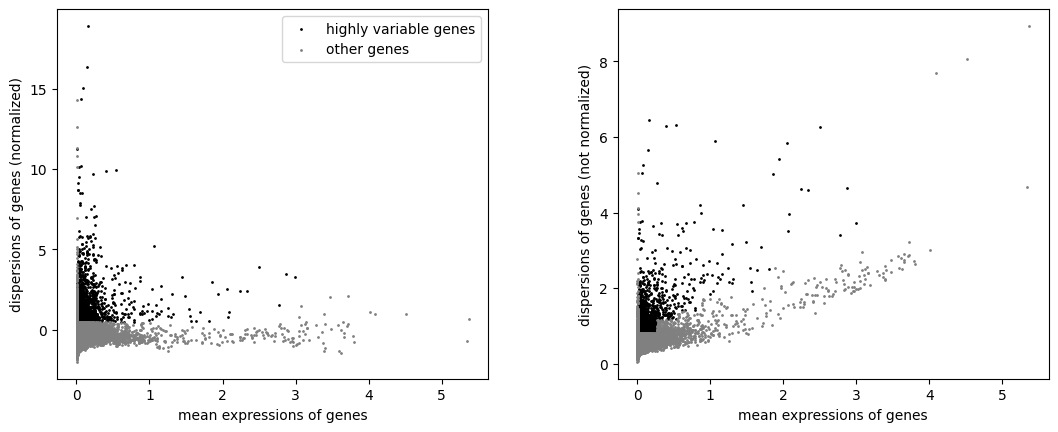

In [16]:
# logtransform before HVG calculation
sc.pp.log1p(adata_beforeCorrection)

sc.pp.highly_variable_genes(adata_beforeCorrection)
sc.pl.highly_variable_genes(adata_beforeCorrection)

In [17]:
# print how many HVGs we have:
print("Nr of HVGs:")
print(sum(adata_beforeCorrection.var.highly_variable))

Nr of HVGs:
1823


In [18]:
sc.tl.pca(adata_beforeCorrection, svd_solver='arpack')

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


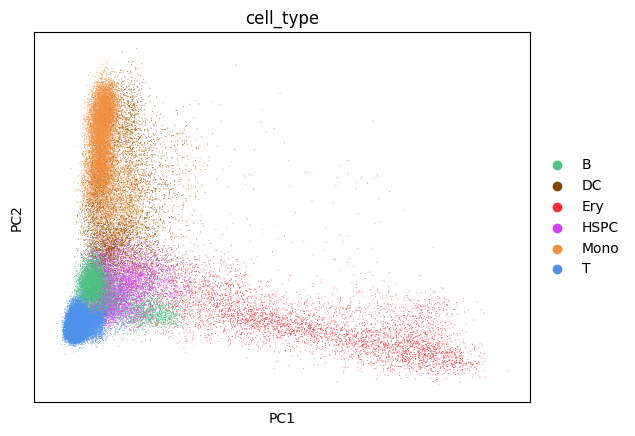

In [19]:
sc.pl.pca(adata_beforeCorrection
          , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_beforeCorrection_cell_type.pdf"
         )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


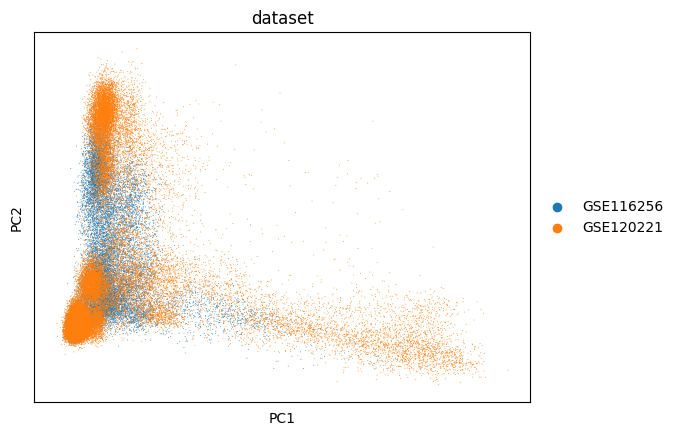

In [20]:
sc.pl.pca(adata_beforeCorrection
          , color=["dataset"]
          ,save="_beforeCorrection_cell_type_dataset.pdf"
         )

In [21]:
sc.pp.neighbors(adata_beforeCorrection)

In [22]:
sc.tl.umap(adata_beforeCorrection)

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


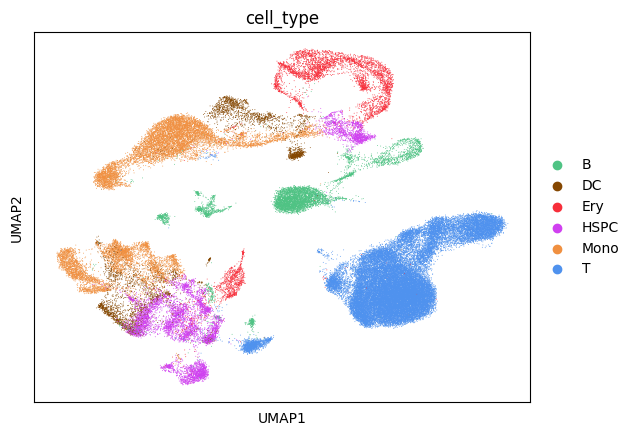

In [23]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_beforeCorrection_cell_type.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


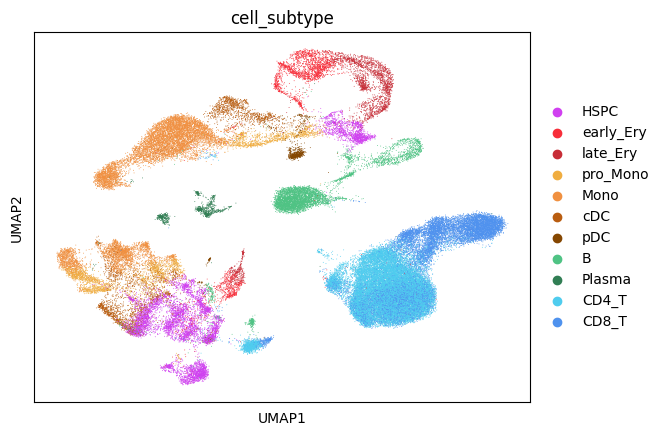

In [24]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_subtype"]
          ,palette=colors_cell_subtype
          ,save="_beforeCorrection_cell_subtype.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


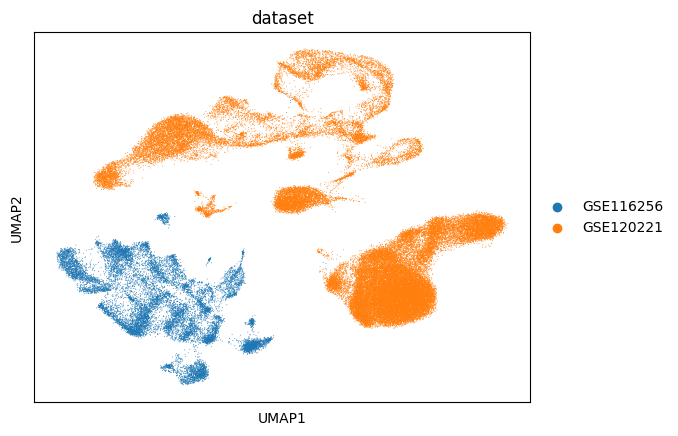

In [25]:
sc.pl.umap(adata_beforeCorrection
           , color=["dataset"]
          ,save="_beforeCorrection_dataset.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


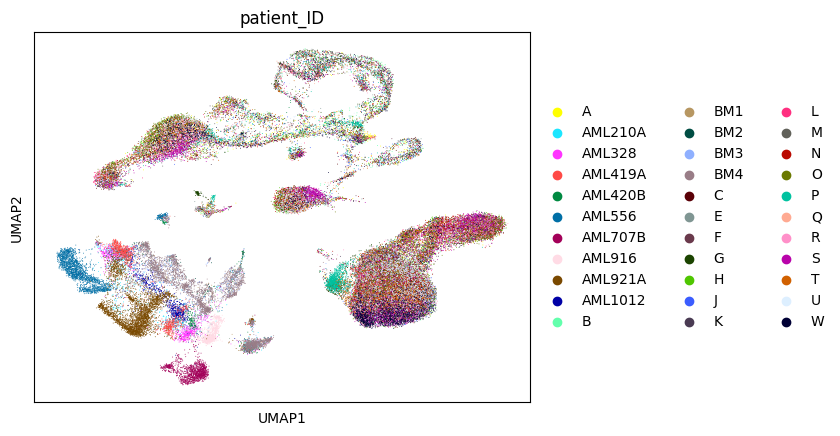

In [26]:
sc.pl.umap(adata_beforeCorrection
           , color=["patient_ID"]
          ,save="_beforeCorrection_patient_ID.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


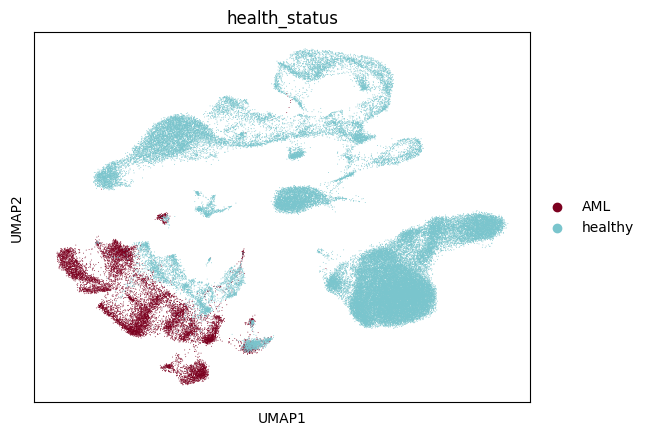

In [27]:
sc.pl.umap(adata_beforeCorrection
           , color=["health_status"]
          ,save="_beforeCorrection_health_status.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


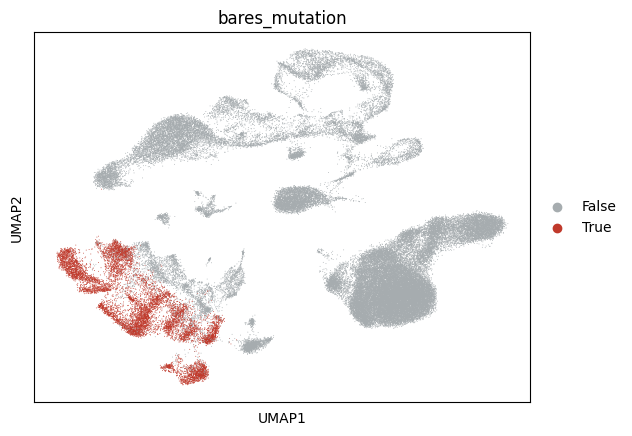

In [28]:
sc.pl.umap(adata_beforeCorrection
           , color=["bares_mutation"]
          ,save="_beforeCorrection_malignant.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


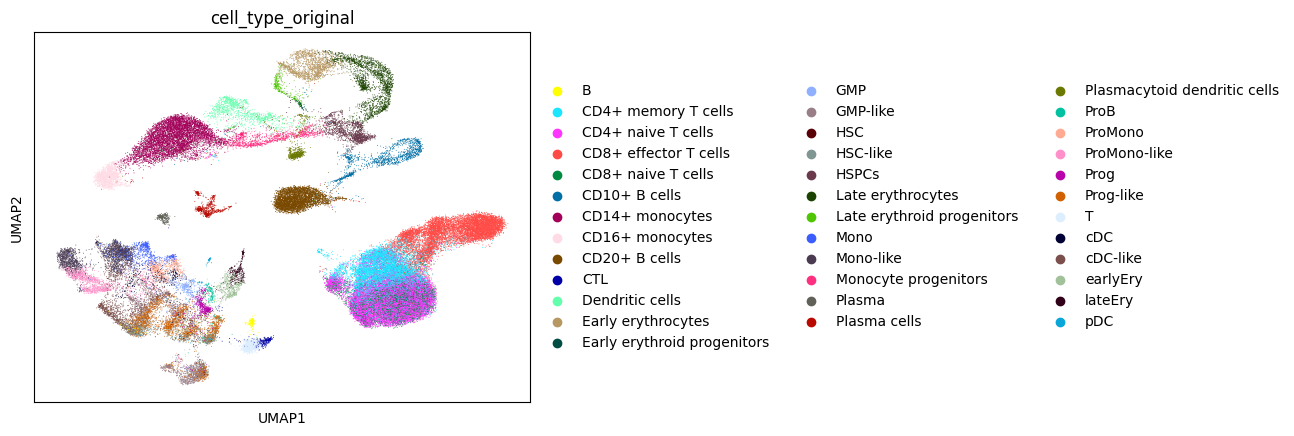

In [29]:
sc.pl.umap(adata_beforeCorrection
           , color=["cell_type_original"]
          ,save="_beforeCorrection_cell_type_original.pdf"
          )

### batch correction

In [30]:
# preprocess for batch correction
scgen.SCGEN.setup_anndata(adata_beforeCorrection, batch_key="dataset", labels_key="cell_type")

In [31]:
# create model
network = scgen.SCGEN(adata_beforeCorrection)

In [32]:
# train model
network.train(max_epochs=100,
            batch_size=32,
            early_stopping=True,
            early_stopping_patience=25,
)


Multiprocessing is handled by SLURM.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 26/100:  26%|████████████████████████████████▏                                                                                           | 26/100 [10:12:52<29:04:20, 1414.33s/it, loss=292, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 1364.404. Signaling Trainer to stop.


In [33]:
# remove batch effect
adata_afterCorrection =  network.batch_removal()

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [34]:
# restore annotations
adata_afterCorrection.var = anno_genes
adata_afterCorrection.var.index = adata_afterCorrection.var.index.astype(str)
adata_afterCorrection.var_names=anno_genes['gene_symbol']
print("adata_afterCorrection.var_names[1:10]")
print(adata_afterCorrection.var_names[1:10])

adata_afterCorrection.var_names[1:10]
Index(['A1BG-AS1', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AADAT', 'AAED1',
       'AAGAB', 'AAK1'],
      dtype='object', name='gene_symbol')


In [35]:
adata_afterCorrection.obs = anno_cells
adata_afterCorrection.obs.index = adata_afterCorrection.obs.index.astype(str)
adata_afterCorrection.obs_names=anno_cells['cell_ID']
print("adata_afterCorrection.obs_names[1:10]")
print(adata_afterCorrection.obs_names[1:10])

adata_afterCorrection.obs_names[1:10]
Index(['AML1012-D0_AAAACACCAATC', 'AML1012-D0_AAAATAGCCTTT',
       'AML1012-D0_AAACATTAAACG', 'AML1012-D0_AAACCACGTGCN',
       'AML1012-D0_AAACGCTGGAAN', 'AML1012-D0_AAACTGGTACTA',
       'AML1012-D0_AAACTTGCCCGT', 'AML1012-D0_AAATGAAAGTCC',
       'AML1012-D0_AAATGTACGGTA'],
      dtype='object', name='cell_ID')


In [36]:
print("adata_afterCorrection")
print(adata_afterCorrection)

adata_afterCorrection
AnnData object with n_obs × n_vars = 74583 × 12485
    obs: 'cell_ID', 'cell_type_original', 'sample_ID', 'malignant', 'patient_ID', 'dataset', 'gender', 'age', 'health_status', 'case_or_control', 'day', 'cell_type', 'cell_subtype', 'cell_type_original_datasetName', 'total_counts_raw', 'mito_counts', 'frac_mito', 'nr_genes', 'counts_upper_threshold', 'counts_lower_threshold', 'genes_lower_threshold', 'counts_vs_genes_threshold', 'counts_upper_filter', 'counts_lower_filter', 'genes_lower_filter', 'counts_vs_genes_filter', 'cell_filter', 'threshold_celltype_size', 'celltype_size_cf', 'celltype_size_filter', 'cell_type_ID', 'total_counts_raw_cf_ctf_gf', 'total_counts_raw_cf_ctf_gf_sf', 'sizeFactor', 'bares_mutation', '_scvi_batch', '_scvi_labels'
    var: 'gene_symbol', 'is_in_LR_database', 'isLigand', 'isReceptor', 'sum_pseudobulkCellType_expr', 'sum_pseudobulkCellType_expr_threshold', 'sum_pseudobulkCellType_expr_filter', 'highly_variable', 'means', 'dispersions', 

### visualize after batch correction

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


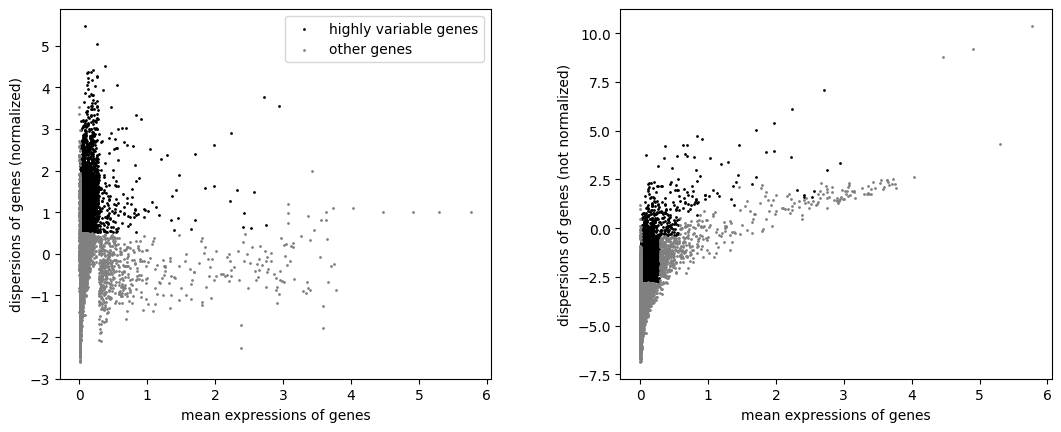

In [37]:
sc.pp.highly_variable_genes(adata_afterCorrection)
sc.pl.highly_variable_genes(adata_afterCorrection)

In [38]:
print("Nr of HVGs:")
print(sum(adata_afterCorrection.var.highly_variable))

Nr of HVGs:
3050


In [39]:
sc.tl.pca(adata_afterCorrection, svd_solver='arpack')

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


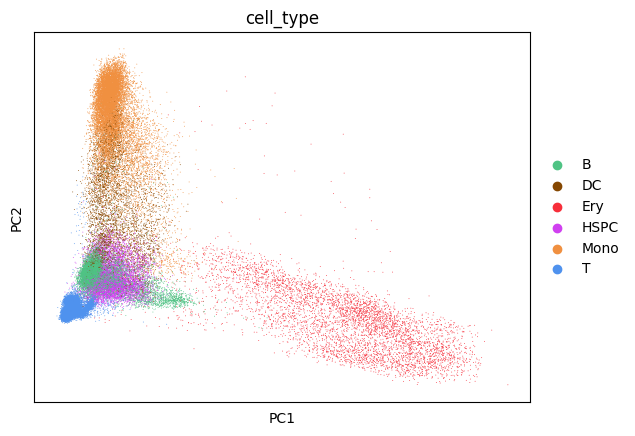

In [40]:
sc.pl.pca(adata_afterCorrection
          , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_afterCorrection_cell_type.pdf"
         )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


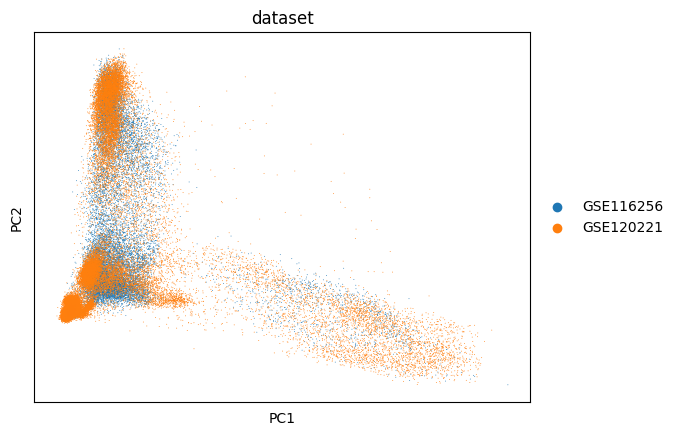

In [41]:
sc.pl.pca(adata_afterCorrection
          , color=["dataset"]
          ,save="_afterCorrection_cell_type_dataset.pdf"
         )

In [42]:
sc.pp.neighbors(adata_afterCorrection)

In [43]:
sc.tl.umap(adata_afterCorrection)

In [44]:
adata_afterCorrection.uns["health_status_colors"] = ["#7C001F" # bordeau for AML
                                                     , "#7ac5cd" # CadetBlue3 for healthy
                                                     ]

In [45]:
adata_afterCorrection.uns["bares_mutation_colors"] = ["#A6ACAF" # grey for FALSE
                                                  , "#C0392B" # red for TRUE
                                                 ]

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


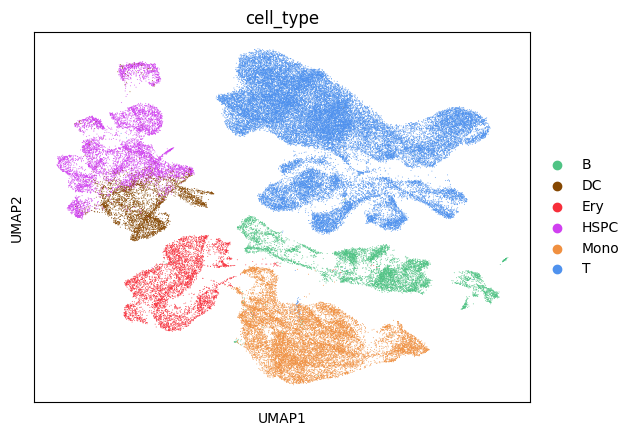

In [46]:
sc.pl.umap(adata_afterCorrection
           , color=["cell_type"]
          ,palette=colors_cell_type
          ,save="_afterCorrection_cell_type.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


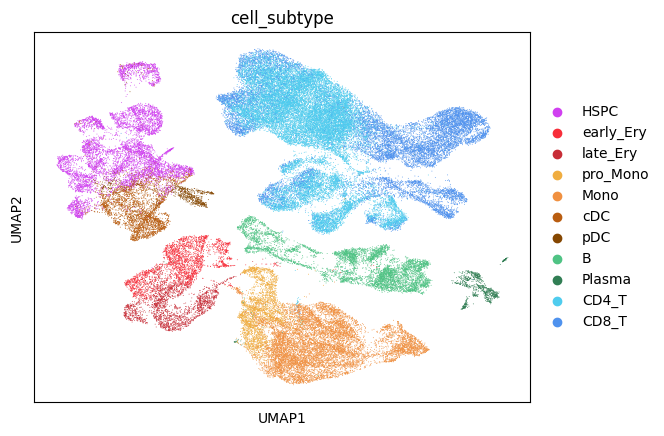

In [47]:
sc.pl.umap(adata_afterCorrection
           , color=["cell_subtype"]
          ,palette=colors_cell_subtype
          ,save="_afterCorrection_cell_subtype.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


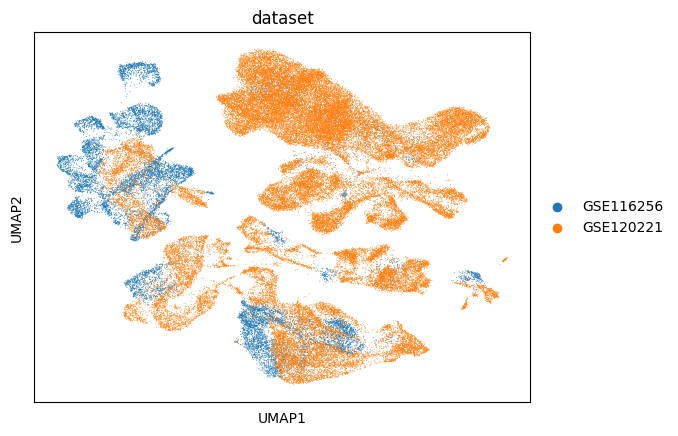

In [48]:
sc.pl.umap(adata_afterCorrection
           , color=["dataset"]
          ,save="_afterCorrection_dataset.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


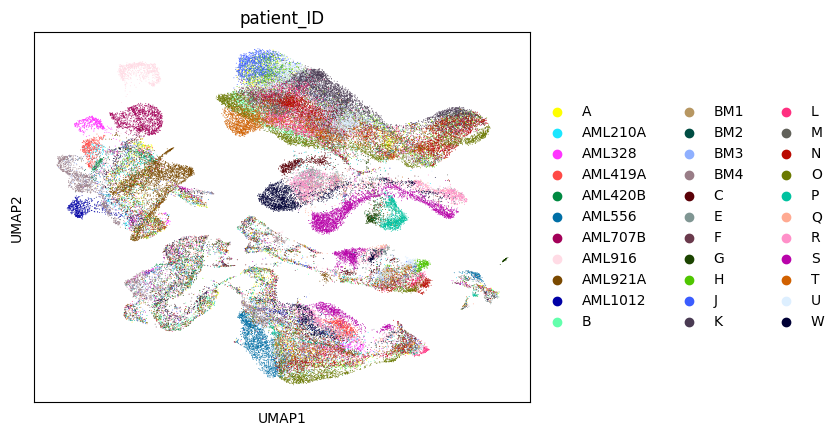

In [49]:
sc.pl.umap(adata_afterCorrection
           , color=["patient_ID"]
          ,save="_afterCorrection_patient_ID.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


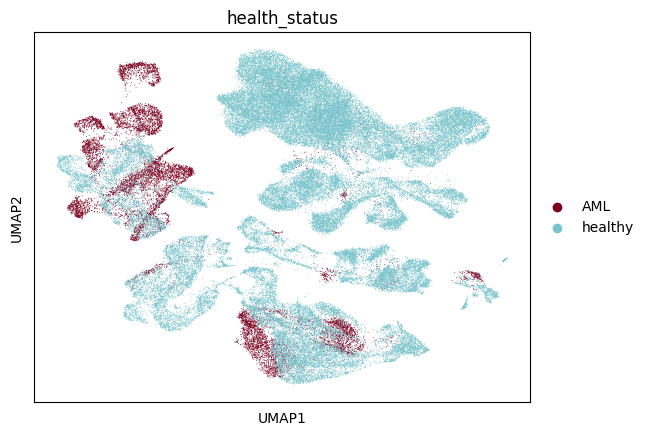

In [50]:
sc.pl.umap(adata_afterCorrection
           , color=["health_status"]
          ,save="_afterCorrection_health_status.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


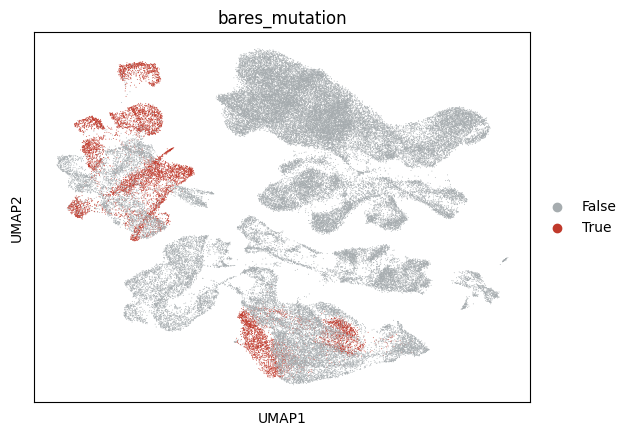

In [51]:
sc.pl.umap(adata_afterCorrection
           , color=["bares_mutation"]
          ,save="_afterCorrection_malignant.pdf"
          )

/home/mcelik/miniconda3/envs/tf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


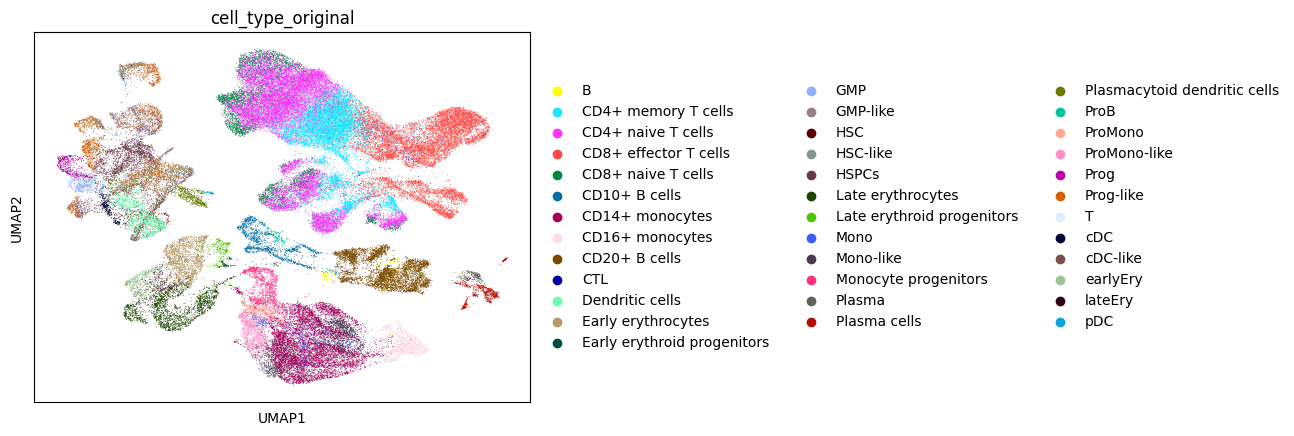

In [52]:
sc.pl.umap(adata_afterCorrection
           , color=["cell_type_original"]
          ,save="_afterCorrection_cell_type_original.pdf"
          )

# Export

In [53]:
# export counts as csv.gz
print("save counts_corr.csv.gz")

counts_corr=pd.DataFrame(adata_afterCorrection.X
                        ,columns=adata_afterCorrection.var_names 
                        ,index=adata_afterCorrection.obs_names
                        ).transpose()
counts_corr.to_csv("counts_corr.csv.gz"
                   ,index=True
                   ,compression="gzip"
                   )

save counts_corr.csv.gz


In [54]:
# export anno_cells_corr
print("save anno_cells_corr.txt")
adata_afterCorrection.obs.to_csv("anno_cells_corr.txt"
                    ,sep = "\t"
                    ,index = True)


save anno_cells_corr.txt


In [55]:
# export anno_samples_corr
print("save anno_samples_corr.txt")
anno_samples.to_csv("anno_samples_corr.txt"
                    ,sep = "\t"
                    ,index = True)

save anno_samples_corr.txt


In [56]:
# export anno_genes_corr
print("save anno_genes_corr.txt")
adata_afterCorrection.var.to_csv("anno_genes_corr.txt"
                    ,sep = "\t"
                    ,index = True)

save anno_genes_corr.txt


In [57]:
# export adata object
print("save adata_afterCorrection.h5ad")
adata_afterCorrection.write("adata_afterCorrection.h5ad")

save adata_afterCorrection.h5ad
